<a href="https://colab.research.google.com/github/sydney-machine-learning/sentimentanalysis-USelections/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA_1

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import io
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from textblob import TextBlob
from nltk.util import ngrams
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read the tweets
Trump_dataset = pd.read_csv("/content/drive/MyDrive/US_elections/hashtag_donaldtrump.csv", lineterminator='\n')
Biden_dataset = pd.read_csv("/content/drive/MyDrive/US_elections/hashtag_joebiden.csv", lineterminator='\n')

In [ ]:
Trump_dataset.head()

created_at      tweet_id  ... state_code                   collected_at
0  2020-10-15 00:00:01  1.316529e+18  ...         FL            2020-10-21 00:00:00
1  2020-10-15 00:00:01  1.316529e+18  ...        NaN  2020-10-21 00:00:00.373216530
2  2020-10-15 00:00:02  1.316529e+18  ...         OR  2020-10-21 00:00:00.746433060
3  2020-10-15 00:00:02  1.316529e+18  ...        NaN  2020-10-21 00:00:01.119649591
4  2020-10-15 00:00:08  1.316529e+18  ...         DC  2020-10-21 00:00:01.492866121

[5 rows x 21 columns]

Drop useless column

In [ ]:
Trump_dataset = Trump_dataset.drop(columns = ['tweet_id','collected_at','user_description','collected_at'])
Biden_dataset = Biden_dataset.drop(columns = ['tweet_id','collected_at','user_description','collected_at'])

Merge Datasets

In [ ]:
Trump_dataset.loc[:,'condidat'] = 'Trump'
Biden_dataset.loc[:,'condidat'] = 'Biden'

In [ ]:
Data_Mixed = pd.concat([Trump_dataset,Biden_dataset])
Data_Mixed.sort_values(by='created_at')
Data_Mixed.head()

created_at  ... condidat
0  2020-10-15 00:00:01  ...    Trump
1  2020-10-15 00:00:01  ...    Trump
2  2020-10-15 00:00:02  ...    Trump
3  2020-10-15 00:00:02  ...    Trump
4  2020-10-15 00:00:08  ...    Trump

[5 rows x 19 columns]

Number of tweets

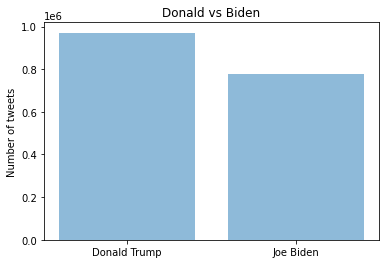

In [ ]:
Trump_tweets = Data_Mixed.query('(condidat == "Trump")').tweet.sort_values(ascending=False).count()
Biden_tweets = Data_Mixed.query('(condidat == "Biden")').tweet.sort_values(ascending=False).count()

objects = ('Donald Trump','Joe Biden')
y_pos = np.arange(len(objects))
performance = [Trump_tweets,Biden_tweets]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of tweets')
plt.title('Donald vs Biden')

plt.show()

Number of likes

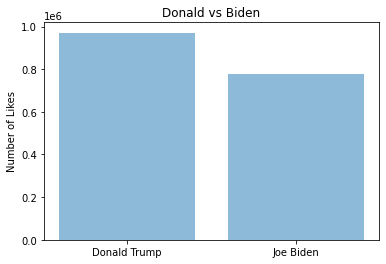

In [ ]:
Trump_tweets = Data_Mixed.query('(condidat == "Trump")').likes.count()
Biden_tweets = Data_Mixed.query('(condidat == "Biden")').likes.count()

objects = ('Donald Trump','Joe Biden')
y_pos = np.arange(len(objects))
performance = [Trump_tweets,Biden_tweets]

plt.bar(y_pos, performance, align='center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Likes')
plt.title('Donald vs Biden')

plt.show()

In [ ]:
class Chart_builder:
    
    def __init__(self,topic_index,number):
        super().__init__()
        self.topic_index = topic_index
        self.topics_list = ['source','country','state','continent','city']
        self.number      = number
        self.index = self.topics_list[self.topic_index]
        self.Trump_tweets_sources_x = Data_Mixed.query('(condidat == "Trump")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number].index
        
        self.Trump_tweets_sources_y = Data_Mixed.query('(condidat == "Trump")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number]
        
        self.Biden_tweets_sources_x = Data_Mixed.query('(condidat == "Biden")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number].index
        
        self.Biden_tweets_sources_y = Data_Mixed.query('(condidat == "Biden")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number]
    
    def Builder(self):
        fig = go.Figure([go.Bar(x = self.Trump_tweets_sources_x, y = self.Trump_tweets_sources_y, name = 'Trump'),
                         go.Bar(x = self.Biden_tweets_sources_x, y = self.Biden_tweets_sources_y, name = 'Biden')])
        # Customize aspect
        fig.update_layout(title_text = 'top '+ str(self.number) + ' ' + self.index)
        fig.update_xaxes(title = 'sources')
        fig.update_yaxes(title = 'tweets count')
        fig.show()

Top 10 source of tweets

In [ ]:
topic_index = 0
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()

Sentiment Analysis

In [ ]:
def clean(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    return text

# create fuction to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score==0:
        return 'neutral'
    else:
        return 'positive'

# Trump Sentiments

In [ ]:
Trump_Tweets = Data_Mixed.query('(condidat == "Trump")').sort_values('user_followers_count',ascending = False).drop_duplicates(['user_name'])[['tweet','country']]
Trump_Tweets = Trump_Tweets.dropna().loc[Trump_Tweets.country == 'United States of America'][:1000]

Trump_Tweets.reset_index(inplace = True, drop = True)

Trump_Tweets['ClearTweet'] = Trump_Tweets['tweet'].apply(clean)

Trump_Tweets['subjectivity']= Trump_Tweets['ClearTweet'].apply(getSubjectivity)
Trump_Tweets['polarity']    = Trump_Tweets['ClearTweet'].apply(getPolarity)
Trump_Tweets['analysis']    = Trump_Tweets['polarity'].apply(getAnalysis)
Trump_Tweets.head()


Trump_Tweets.head()

tweet  ...  analysis
0  Without a doubt, the #FourSeasons debacle is t...  ...  positive
1  President Donald #Trump’s youngest daughter, T...  ...   neutral
2  Woah. Have you read this article?\n\nAll the p...  ...   neutral
3  The latest episode of #SNL tackled #DonaldTrum...  ...  negative
4  🇺🇸 #Decision2020: @JoeBiden firmará una serie ...  ...   neutral

[5 rows x 6 columns]

In [ ]:
%%time
Trump_Tweets.polarity = Trump_Tweets.polarity.apply(lambda x: getAnalysis(x))

CPU times: user 1.38 ms, sys: 953 µs, total: 2.33 ms
Wall time: 2.73 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

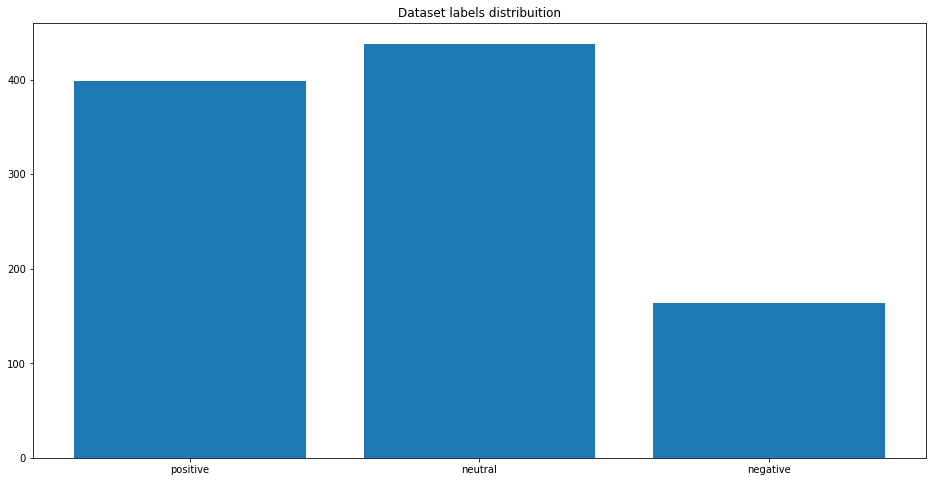

In [ ]:
from collections import Counter

target_cnt = Counter(Trump_Tweets.polarity)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
general  = Trump_Tweets.groupby('analysis').analysis.count()
neutral  = Trump_Tweets[Trump_Tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = Trump_Tweets[Trump_Tweets['analysis'] == 'positive'].ClearTweet.count()
negative = Trump_Tweets[Trump_Tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positivity","negativity","neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='sentimat analysis tweets Donald Trump')
fig.show()

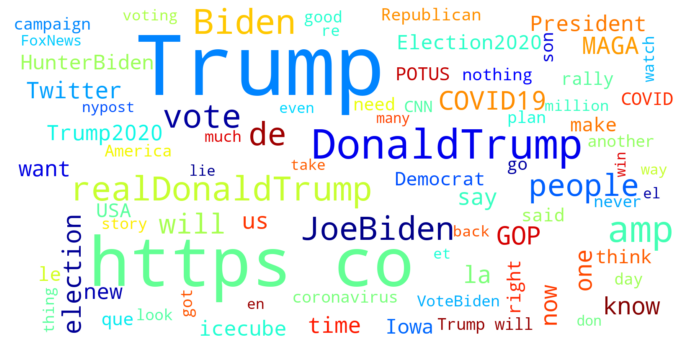

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(Trump_dataset['tweet'][0:1000])

# Biden Sentiments

In [ ]:
Biden_Tweets = Data_Mixed.query('(condidat == "Biden")').sort_values('user_followers_count',ascending = False).drop_duplicates(['user_name'])[['tweet','country']]
Biden_Tweets = Biden_Tweets.dropna().loc[Biden_Tweets.country == 'United States of America'][:1000]


Biden_Tweets.reset_index(inplace = True, drop = True)

Biden_Tweets['ClearTweet'] = Biden_Tweets['tweet'].apply(clean)

 
Biden_Tweets['subjectivity']= Biden_Tweets['ClearTweet'].apply(getSubjectivity)
Biden_Tweets['polarity']    = Biden_Tweets['ClearTweet'].apply(getPolarity)
Biden_Tweets['analysis']    = Biden_Tweets['polarity'].apply(getAnalysis)
Biden_Tweets.head()


Biden_Tweets.head()

tweet  ...  analysis
0  #JoeBiden is enlisting A-list star power to he...  ...   neutral
1  While we were campaigning across battleground ...  ...  positive
2  The big fight TODAY!!!!! @realDonaldTrump vs #...  ...   neutral
3  During his victory speech, #JoeBiden said he u...  ...  negative
4  Los nueve minutos de colorida celebración tras...  ...   neutral

[5 rows x 6 columns]

In [ ]:
%%time
Biden_Tweets.polarity = Biden_Tweets.polarity.apply(lambda x: getAnalysis(x))

CPU times: user 1.66 ms, sys: 36 µs, total: 1.69 ms
Wall time: 1.55 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

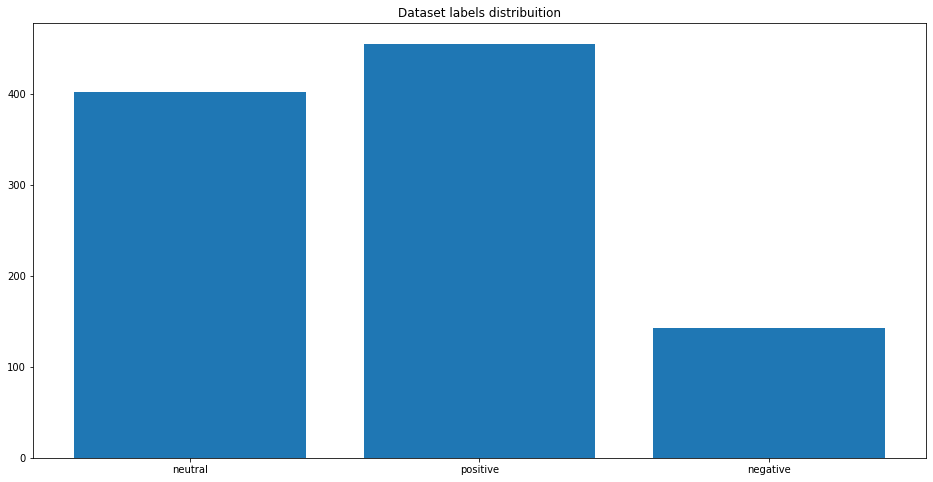

In [ ]:
target_cnt = Counter(Biden_Tweets.polarity)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
general  = Biden_Tweets.groupby('analysis').analysis.count()
neutral  = Biden_Tweets[Biden_Tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = Biden_Tweets[Biden_Tweets['analysis'] == 'positive'].ClearTweet.count()
negative = Biden_Tweets[Biden_Tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positivity","negativity","neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='sentimat analysis tweets Joe Biden')
fig.show()

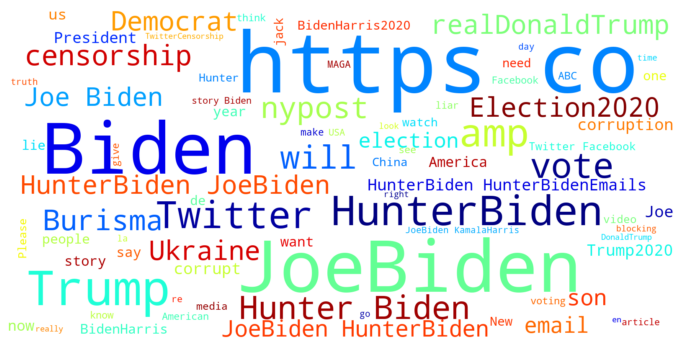

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(Biden_dataset['tweet'][0:1000])

# EDA_2

In [2]:
import numpy as np

# data processing/manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
import re

# data visualization
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px

# stopwords, tokenizer, stemmer
import nltk  
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

# spell correction, lemmatization
from textblob import TextBlob
from textblob import Word

# sklearn
from sklearn.model_selection import train_test_split

In [10]:
trump_df = pd.read_csv('/content/drive/MyDrive/US_elections/cleaned_sample_100_trump.csv', lineterminator='\n')
biden_df = pd.read_csv('/content/drive/MyDrive/US_elections/cleaned_sample_100_biden.csv', lineterminator='\n')

In [11]:
import nltk
nltk.download('stopwords')

to_remove = r'\d+|http?\S+|[^A-Za-z0-9]+'
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# Function to preprocess tweet 
def clean_tweet(tweet, stem=False, lemmatize=False):

    # Make all text lowercase
    tweet = tweet.lower()
    
    # Remove links, special characters, punctuation, numbers, etc.
    tweet = re.sub(to_remove, ' ', tweet)
        
    filtered_tweet = []
    words = word_tokenize(tweet) 

    # Remove stopwords and stem
    for word in words:
        if not word in stop_words:
            if stem:
                filtered_tweet.append(ps.stem(word))
            elif lemmatize:
                filtered_tweet.append(Word(word).lemmatize())
            else:
                filtered_tweet.append(word)
            
    return filtered_tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Filtering all trump and biden tweets by applying cleantweet()
nltk.download('punkt')
trump_df.tweet = trump_df.tweet.apply(lambda x: clean_tweet(x))
biden_df.tweet = biden_df.tweet.apply(lambda x: clean_tweet(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


KeyboardInterrupt: ignored

In [28]:
trump_df.head()

user_id  ... Sentiment
0   1081.0  ...   neutral
1   2654.0  ...   neutral
2   2654.0  ...  positive
3   2654.0  ...  positive
4   2654.0  ...  positive

[5 rows x 9 columns]

SENTIMENTS

In [14]:
# Function to perform sentitment analysis on trump and biden dataframes
def sentiment_analysis(df):
    
    # Determine polarity and subjectivity
    df['Polarity'] = df['tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    df['Subjectivity'] = df['tweet'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)
    
    # Classify overall sentiment
    df.loc[df.Polarity > 0,'Sentiment'] = 'positive'
    df.loc[df.Polarity == 0,'Sentiment'] = 'neutral'
    df.loc[df.Polarity < 0,'Sentiment'] = 'negative'
    
    return df[['tweet','Polarity','Subjectivity','Sentiment']].head()

In [15]:
# Perform sentiment analysis on trump_df
sentiment_analysis(trump_df)

tweet  ...  Sentiment
0                  [finally, foxnews, called, biden]  ...    neutral
1  [oh, takes, back, days, cub, reporter, clevela...  ...    neutral
2  [oh, bet, parents, old, neighborhood, upper, a...  ...   positive
3  [couldnt, last, night, woke, glorious, news, b...  ...   positive
4  [watched, biden, home, scranton, need, decent,...  ...   positive

[5 rows x 4 columns]

In [16]:
# Perform sentiment analysis on biden_df
sentiment_analysis(biden_df)

tweet  ...  Sentiment
0  TwitchSupport I know you are busy trying to st...  ...    neutral
1  RickSantorum  you are soo delusional that Trum...  ...    neutral
2  Wonderful irony that a major factor in AZ was ...  ...    neutral
3  OK, Trump Cabinet youve totally wimped out on ...  ...    neutral
4  Kinda think it would be cool to dust off an ol...  ...    neutral

[5 rows x 4 columns]

Data Visualization

In [17]:
# Overall sentiment breakdown - Trump 
print("Trump Tweet Sentiment Breakdown")

trump_positive = len(trump_df.loc[trump_df.Sentiment=='positive'])
trump_neutral = len(trump_df.loc[trump_df.Sentiment=='neutral'])
trump_negative = len(trump_df.loc[trump_df.Sentiment=='negative'])

print("Number of Positive Tweets: ", trump_positive)
print("Number of Neutral Tweets: ", trump_neutral)
print("Number of Negative Tweets: ", trump_negative)

Trump Tweet Sentiment Breakdown
Number of Positive Tweets:  52665
Number of Neutral Tweets:  61238
Number of Negative Tweets:  23984


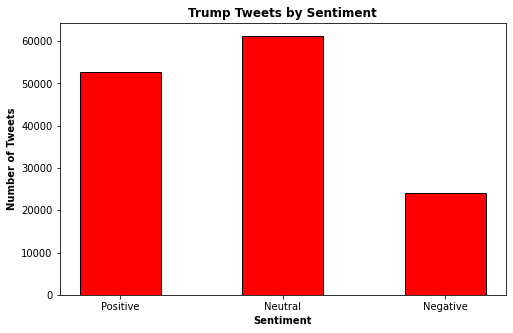

In [18]:
# Graphing the number of trump tweets by sentiment
data_t = {'Positive':trump_positive,'Neutral':trump_neutral,'Negative':trump_negative}
sentiment_t = list(data_t.keys()) 
num_tweets_t = list(data_t.values()) 

plt.figure(figsize = (8, 5)) 

plt.bar(sentiment_t, num_tweets_t, color ='red', width = 0.5, edgecolor='black',) 

plt.xlabel("Sentiment", fontweight ='bold') 
plt.ylabel("Number of Tweets", fontweight ='bold') 
plt.title("Trump Tweets by Sentiment", fontweight ='bold') 
plt.show() 

In [19]:
# Overall sentiment breakdown - Biden 
print("Biden Tweet Sentiment Breakdown")

biden_positive = len(biden_df.loc[biden_df.Sentiment=='positive'])
biden_neutral = len(biden_df.loc[biden_df.Sentiment=='neutral'])
biden_negative = len(biden_df.loc[biden_df.Sentiment=='negative'])

print("Number of Positive Tweets: ", biden_positive)
print("Number of Neutral Tweets: ", biden_neutral)
print("Number of Negative Tweets: ", biden_negative)

Biden Tweet Sentiment Breakdown
Number of Positive Tweets:  4
Number of Neutral Tweets:  152307
Number of Negative Tweets:  0


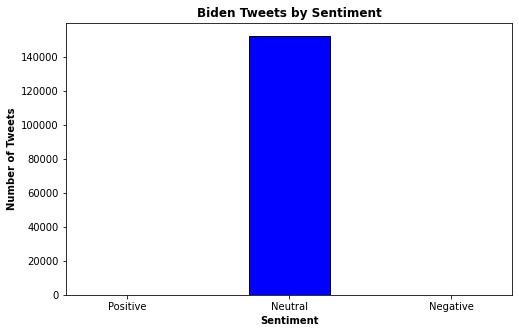

In [20]:
# Graphing the number of biden tweets by sentiment
data_b = {'Positive':biden_positive,'Neutral':biden_neutral,'Negative':biden_negative}
sentiment_b = list(data_b.keys()) 
num_tweets_b = list(data_b.values()) 

plt.figure(figsize = (8, 5)) 

plt.bar(sentiment_b, num_tweets_b, color ='blue', width = 0.5, edgecolor='black') 

plt.xlabel("Sentiment", fontweight ='bold') 
plt.ylabel("Number of Tweets", fontweight ='bold') 
plt.title("Biden Tweets by Sentiment", fontweight ='bold') 
plt.show() 


In [21]:
# Calculate relative percentages by sentiment - Trump
total_tweets_t = len(trump_df.Sentiment)
prop_tweets_t = list(map(lambda x: round(x/total_tweets_t,2), num_tweets_t))

# Calculate relative percentages by sentiment - Biden
total_tweets_b = len(biden_df.Sentiment)
prop_tweets_b = list(map(lambda x: round(x/total_tweets_b,2), num_tweets_b))

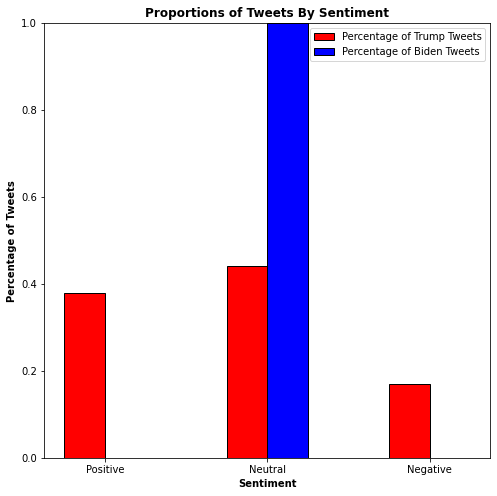

In [22]:
# Graphing relative percentages of both trump and biden tweets
bar_width = 0.25
plt.subplots(figsize=(8,8))

br1 = np.arange(3) 
br2 = [x + bar_width for x in br1] 

t = plt.bar(br1, prop_tweets_t, color ='r', width = bar_width, 
            edgecolor ='black', label ='Trump') 
b = plt.bar(br2, prop_tweets_b, color ='b', width = bar_width, 
            edgecolor ='black', label ='Biden') 
   
plt.xlabel('Sentiment',fontweight ='bold') 
plt.ylabel('Percentage of Tweets',fontweight ='bold') 
plt.xticks([r + bar_width/2 for r in range(3)],['Positive','Neutral','Negative'])
plt.legend([t,b],['Percentage of Trump Tweets','Percentage of Biden Tweets'])
plt.ylim(0.0, 1.0)
plt.title('Proportions of Tweets By Sentiment',fontweight ='bold')

plt.show()

In [24]:
# Function to return a string of all words in all tweets
def get_all_tweets(df,by_sentiment=False,sentiment="positive"):
    
    # Combine all words in tweets into a string
    if by_sentiment:
        if sentiment == "positive":
            words = ' '.join((df.loc[df.Sentiment=='positive'])['tweet'].apply(lambda x: ' '.join(x)))
        elif sentiment == "neutral":
            words = ' '.join((df.loc[df.Sentiment=='neutral'])['tweet'].apply(lambda x: ' '.join(x)))
        else:
            words = ' '.join((df.loc[df.Sentiment=='negative'])['tweet'].apply(lambda x: ' '.join(x)))
    else:
        words = ' '.join(df['tweet'].apply(lambda x: ' '.join(x)))
        
    return words

In [25]:
# Create word strings
words_trump = get_all_tweets(trump_df)
words_pos_trump = get_all_tweets(trump_df,True,"positive")
words_neu_trump = get_all_tweets(trump_df,True,"neutral")
words_neg_trump = get_all_tweets(trump_df,True,"negative")

words_biden = get_all_tweets(biden_df)
words_pos_biden = get_all_tweets(biden_df,True,"positive")
words_neu_biden = get_all_tweets(biden_df,True,"neutral")
words_neg_biden = get_all_tweets(biden_df,True,"negative")

# Tokenize word strings
tokens_trump = word_tokenize(words_trump)
tokens_pos_trump = word_tokenize(words_pos_trump)
tokens_neu_trump = word_tokenize(words_neu_trump)
tokens_neg_trump = word_tokenize(words_neg_trump)

tokens_biden = word_tokenize(words_biden)
tokens_pos_biden = word_tokenize(words_pos_biden)
tokens_neu_biden = word_tokenize(words_neu_biden)
tokens_neg_biden = word_tokenize(words_neg_biden)

In [26]:
def plot_word_freq(tokens,sentiment,t_or_b,color):
    fdist = FreqDist(tokens)
    fdist_df = pd.DataFrame(fdist.most_common(10), columns = ["Word","Frequency"])
    fig = px.bar(fdist_df, x="Word", y="Frequency",
                 title="<b>Most Frequently Used Words in </b>" + sentiment + " " + t_or_b + "<b>-Related Tweets</b>")
    fig.update_traces(marker=dict(color=color),selector=dict(type="bar"),
                      marker_line_color='black', marker_line_width=1.5, opacity=0.6)
    fig.show()

In [29]:
trump_df.head()

user_id  ... Sentiment
0   1081.0  ...   neutral
1   2654.0  ...   neutral
2   2654.0  ...  positive
3   2654.0  ...  positive
4   2654.0  ...  positive

[5 rows x 9 columns]

In [31]:
# Ploting polarity by state
fig = px.scatter(trump_df, x="state_code", y="Polarity", color="Polarity",
                title="<b>Trump-Related Tweet Polarity by State</b>",
                color_continuous_scale=px.colors.sequential.Inferno,
                width=1000, height=800)
fig.update_xaxes(categoryorder='category ascending')
fig.show()

In [34]:
# Average polarity by state (trump)
trump_state_polarity = trump_df.groupby("state_code",as_index=False).mean()

fig = px.bar(trump_state_polarity, x="state_code", y="Polarity",
            title="<b>Average Polarity of Trump-Related Tweets by State</b>")
fig.update_traces(marker=dict(color="red"),selector=dict(type="bar"),
                  marker_line_color='black', marker_line_width=0.8, opacity=0.6)
fig.show()

In [35]:
# Ploting polarity by state - Biden
fig = px.scatter(biden_df, x="state_code", y="Polarity", color="Polarity",
                title="<b>Biden-Related Tweet Polarity by State</b>",
                color_continuous_scale=px.colors.sequential.Inferno,
                width=1000, height=800)
fig.update_xaxes(categoryorder='category ascending')
fig.show()

In [37]:
# Average polarity by state - Biden
biden_state_polarity = biden_df.groupby("state_code",as_index=False).mean()

fig = px.bar(biden_state_polarity, x="state_code", y="Polarity",
            title="<b>Average Polarity of Biden-Related Tweets by State</b>")
fig.update_traces(marker=dict(color="blue"),selector=dict(type="bar"),
                  marker_line_color='black', marker_line_width=0.8, opacity=0.6)
fig.show()